# Neural Net Language models

> Basic neuralnet-based language modeling 

In [2]:
#| default_exp models.lm

In [3]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [269]:
#| export
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader

import lightning as L
from lightning import Trainer, LightningModule
from lightning.pytorch.tuner.tuning import Tuner
from lightning.pytorch.callbacks import LearningRateFinder
from lightning.pytorch.loggers import CSVLogger



from matplotlib import pyplot as plt
import matplotlib
# plt.set_loglevel('INFO')
import pandas as pd
import numpy as np
from tqdm import tqdm
import pprint

from omegaconf import OmegaConf
from hydra.utils import instantiate

from typing import Dict, List, Tuple, Optional, Set
from dataclasses import dataclass, asdict

from nimrod.text.datasets import CharDataset, Vocab
from nimrod.utils import set_seed, get_device
from nimrod.models.core import Classifier, plot_classifier_metrics_from_csv
import nimrod

import logging

logger = logging.getLogger(__name__)
# N_EPOCHS for training debuggging
ITER_MAX = 1

In [5]:
set_seed(42)

Seed set to 42


In [6]:
# reading with pandas
df = pd.read_csv('../data/text/names.txt', header=None, names=['name'])
data = list(df.name)
print("names: ", data[:3])

names:  ['emma', 'olivia', 'ava']


## Data formatting
given last n tokens we predict token n+1

In [7]:
s = list("alexandra")
print(s)
bigram = [(x,y) for x, y in zip(s, s[1:])]
print(bigram)
trigram = [ (x,y,z) for x, y, z in zip(s, s[1:], s[2:])]
print(trigram)

['a', 'l', 'e', 'x', 'a', 'n', 'd', 'r', 'a']
[('a', 'l'), ('l', 'e'), ('e', 'x'), ('x', 'a'), ('a', 'n'), ('n', 'd'), ('d', 'r'), ('r', 'a')]
[('a', 'l', 'e'), ('l', 'e', 'x'), ('e', 'x', 'a'), ('x', 'a', 'n'), ('a', 'n', 'd'), ('n', 'd', 'r'), ('d', 'r', 'a')]


### Tiny shakespeare LM char dataset

In [8]:
# reading directly in plain python
lines = []
with open('../data/text/tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        if line.strip():
            # only append non blank lines
            lines.append(line)

# add sentence tokens
# data = [['<bos>'] +list(line.strip()) + ['<eos>'] for line in lines]
# data = [list(line.strip()) for line in lines]
data = [list(line) for line in lines]
print("data: ", data[:3])

data:  [['F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '\n'], ['B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '\n'], ['A', 'l', 'l', ':', '\n']]


In [9]:

def make_dataset(
        words:List[str], # data is a list of sentences which are a list of words
        v:Vocab,# vocabulary class for mapping words to indices
        verbose:bool=False, # print debug info
        context_length=3 # number of words/tokens to use as context
        ):
    X = []
    y = []
    for word in words:
        s = list(word)
        if verbose:
            print('row: ', s)
        # init prefix with padding while len < context_length
        for i in range(context_length-1):
            sequence = v.stoi(s[:i+1])
            pad_len = context_length - len(sequence)
            pad = [v.stoi("<pad>")] * pad_len
            X.append(pad + sequence)
            y.append(v.stoi(s[i+1]))

            if verbose:
                print(["<pad>"]+ s[:i+1], s[i+1])

        # for length seq = context_length
        i = 0
        while i < (len(s) - context_length):
            X.append(v.stoi(s[i:context_length+i]))
            y.append(v.stoi(s[i+context_length]))
            if verbose:
                print(s[i:context_length+i], s[i+context_length])
            i += 1
    return torch.tensor(X),torch.tensor(y)


for each row in the dataset we expand all the combinations of ngrams

In [10]:
v = Vocab(data_path='../data/text/tiny_shakespeare.txt', specials=['<unk>','<pad>'])
print("vocabulary: ", v.vocabulary)
print("vocabulary size: ", len(v))


vocabulary:  ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '<pad>', '<unk>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vocabulary size:  67


In [11]:
CONTEXT_LEN = 3
X, y = make_dataset(data[:80], v, verbose=True, context_length=CONTEXT_LEN)
print("X: ", X.shape, "y:", y.shape)

row:  ['F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '\n']
['<pad>', 'F'] i
['<pad>', 'F', 'i'] r
['F', 'i', 'r'] s
['i', 'r', 's'] t
['r', 's', 't']  
['s', 't', ' '] C
['t', ' ', 'C'] i
[' ', 'C', 'i'] t
['C', 'i', 't'] i
['i', 't', 'i'] z
['t', 'i', 'z'] e
['i', 'z', 'e'] n
['z', 'e', 'n'] :
['e', 'n', ':'] 

row:  ['B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '\n']
['<pad>', 'B'] e
['<pad>', 'B', 'e'] f
['B', 'e', 'f'] o
['e', 'f', 'o'] r
['f', 'o', 'r'] e
['o', 'r', 'e']  
['r', 'e', ' '] w
['e', ' ', 'w'] e
[' ', 'w', 'e']  
['w', 'e', ' '] p
['e', ' ', 'p'] r
[' ', 'p', 'r'] o
['p', 'r', 'o'] c
['r', 'o', 'c'] e
['o', 'c', 'e'] e
['c', 'e', 'e'] d
['e', 'e', 'd']  
['e', 'd', ' '] a
['d', ' ', 'a'] n
[' ', 'a', 'n'] y
['a', 'n', 'y']  
['n', 'y', ' '] f
['y', ' ', 'f'] u
[' ', '

## MLP LM Model
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [12]:
# F.one_hot(torch.tensor(5), num_classes=n_vocab).float()@C # == C[5]

In [250]:
#| export

@dataclass
class NNLMConfig:
    n_vocab:int = 30
    n_emb:int = 10
    n_context:int = 3
    n_h:int = 100

class NNLM(nn.Module):
    def __init__(self,
                n_vocab:int = 30, # vocabulary size 
                n_emb:int = 10, # embedding dimension
                n_context:int = 3, # context size bigram/trigram, etc.
                n_h:int = 100 # hidden layer size
                ):

        logger.info(f"NNLM: Init")
        super().__init__()
        # to each token id from n_vocab in sequence T coresponds a embedding of size n_emb (C)
        self.embedder = nn.Embedding(n_vocab, n_emb) # (B,T)->(B,T,C)
        self.n_emb = n_emb
        self.n_context = n_context
        # we concatenate input of [n_context length, n_emb] into linear layer (T*C):
        self.l1 = nn.Linear(n_context * n_emb, n_h) 
        self.l2 = nn.Linear(n_h, n_vocab)
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        # input: (B,T)
        embedding = self.embedder(x) # ->(B,T,C)
        # we concatenate input of n_context length * n_emb (T*C) into linear layer:
        h = self.l1(embedding.view(-1,self.n_context * self.n_emb))
        h = torch.tanh(h)
        logits = self.l2(h)
        return(logits)

    @torch.no_grad()
    def sample(self, prompt:str, vocab:Vocab, max_new_tokens:int=50, temperature:float=1.0):

        for _ in range(max_new_tokens):            
            # limit prompt to context size
            context = prompt[-self.n_context:]
            context = vocab.stoi(list(context))

            logits = self(torch.tensor(context))
            logits = logits / temperature
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            prompt += vocab.itos(ix)
        return(prompt)

### Usage

In [251]:
# config model
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM(**asdict(conf))

# test data
bs = 25
x = torch.randint(conf.n_vocab, (bs, conf.n_context)) # (B, T) with values between 0 and n_vocab
print("X (B, T):", x.shape)

# prediction
y = lm(x)
print("Y_hat logits (B, n_vocab):", y.shape)

[12/19/24 13:06:24] INFO     2024-12-19 13:06:24,602 - INFO - NNLM: Init                           ]8;id=507137;file:///var/folders/b5/v9y3kpzs29g41d99xvrdp3yr0000gn/T/ipykernel_63660/1576515260.py\1576515260.py]8;;\:]8;id=124468;file:///var/folders/b5/v9y3kpzs29g41d99xvrdp3yr0000gn/T/ipykernel_63660/1576515260.py#18\18]8;;\

X (B, T): torch.Size([25, 3])
Y_hat logits (B, n_vocab): torch.Size([25, 67])


## Train MLP LM

### handmade dataset

In [15]:
Xtr, Ytr = make_dataset(data[:80], v, context_length=CONTEXT_LEN)
Xdev, Ydev = make_dataset(data[80:90], v)
Xte, Yte = make_dataset(data[90:100], v)
print("Xtr (B, T): ", Xtr.shape, "Ytr (B): ", Ytr.shape, "data:", len(data[:80]))
print("len Xtr: ", len(Xtr))
print("CONTEXT_LEN: ", CONTEXT_LEN)

Xtr (B, T):  torch.Size([2623, 3]) Ytr (B):  torch.Size([2623]) data: 80
len Xtr:  2623
CONTEXT_LEN:  3


#### Overfit on subset of 80 first rows

In [42]:
#| notest

%%time
device = get_device()
device = 'cpu'
# lm.to(device)

# overfit on one big batch
optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []
ITER_MAX = 1000
for i in tqdm(range(ITER_MAX)):
    # for batch in dm.train_dataloader():
        # Xtr, Ytr = batch
        # Ytr = Ytr[:, -1]
        Xtr = Xtr.to(device)
        Ytr = Ytr.to(device)
        optim.zero_grad()
        logits = lm(Xtr)
        loss = F.cross_entropy(logits, Ytr)
        loss.backward()
        optim.step()
        train_loss.append(loss.item())
        if not(i%250):
            print(loss.item())

  5%|▌         | 54/1000 [00:00<00:01, 537.56it/s]

4.255860805511475


 33%|███▎      | 331/1000 [00:00<00:01, 538.77it/s]

2.5862650871276855


 61%|██████    | 608/1000 [00:01<00:00, 521.54it/s]

2.302309274673462


 83%|████████▎ | 828/1000 [00:01<00:00, 541.03it/s]

2.1291682720184326


100%|██████████| 1000/1000 [00:01<00:00, 529.24it/s]

CPU times: user 3.84 s, sys: 1.43 s, total: 5.28 s
Wall time: 1.89 s


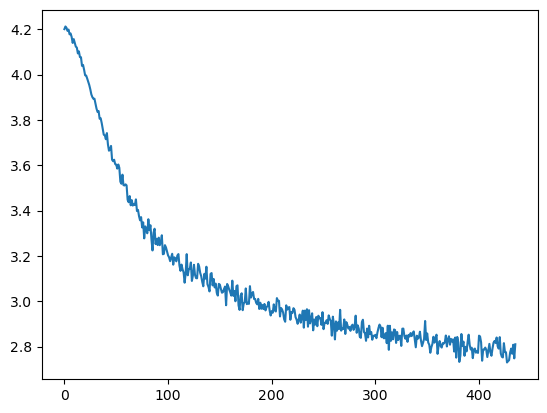

In [246]:
#| notest
plt.plot(train_loss)

#### Sample

In [44]:
# infer on CPU
lm.to('cpu')
prompt = "The country of "
sequences = lm.sample(prompt, v, max_new_tokens=250, temperature=0.6)
print(sequences)


The country of ale she phaknou hat we count the' to te on the knowe parst yie, mure thas you what he peir ouve s are gat we :ortans de she crent the pat way he all as pote stong as the pe ore to bo do ds ireneld to nhe red read de ponltizen:
rite the hone.s phit ru


### Dataloader

In [252]:

cfg = OmegaConf.load("../config/text/data/tinyshakespeare.yaml")
# use <unk> and <pad> to be consistent with manual data preprocessing and have smae vocabulary size
v = Vocab(data_path='../data/text/tiny_shakespeare.txt', specials=['<unk>','<pad>'])
print("vocabulary: ", v.vocabulary)
print("vocabulary size: ", len(v))
print(cfg)
cfg.train_val_test_split = [0.8, 0.1, 0.1]
# by default data_path is relative to the recipe folder so need to update for nbs
cfg.data_path = "../data/text/tiny_shakespeare.txt"
cfg.context_size = CONTEXT_LEN
cfg.batch_size = 2700 # large batch to mimic manual data order of magnitude
cfg.random_split = False
cfg.specials=['<unk>', '<pad>']
cfg.add_sentence_tokens = False
print(cfg)
dm = instantiate(cfg)
dm.setup()
print("vocab size: ", dm.vocab_size)
# setup large batch to overfit / test model
Xtr, Ytr= next(iter(dm.train_dataloader()))
# target is last token in sequence
Ytr = Ytr[:, -1]
print("Xtr (B, T): ", Xtr.shape, "Ytr (B): ", Ytr.shape)
X, Y = dm.data_train[0]
print(dm.ds.from_tokens(X), dm.ds.from_tokens(Y))


[12/19/24 13:06:35] INFO     2024-12-19 13:06:35,983 - INFO - Vocab: read text file                  ]8;id=16567;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=427819;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#66\66]8;;\

vocabulary:  ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '<pad>', '<unk>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vocabulary size:  67
{'_target_': 'nimrod.text.datasets.CharDataModule', 'data_path': '../data/text/tiny_shakespeare.txt', 'specials': ['<pad>', '<unk>'], 'add_sentence_tokens': False, 'train_val_test_split': [0.8, 0.1, 0.1], 'random_split': False, 'batch_size': 64, 'context_size': 3, 'num_workers': 0, 'pin_memory': False, 'persistent_workers': False}
{'_target_': 'nimrod.text.datasets.CharDataModule', 'data_path': '../data/text/tiny_shakespeare.txt', 'specials': ['<unk>', '<pad>'], 'add_sentence_tokens': False, 'train_val_test_split': [0.8, 0.1, 0.1], 'random_split': False, 'batch_size': 2700, 'context_size': 3, 'num_workers': 0, 'pi

                    INFO     2024-12-19 13:06:35,993 - INFO - CharDataModule: init                  ]8;id=994808;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=705845;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#213\213]8;;\

                    INFO     2024-12-19 13:06:35,995 - INFO - CharDataModule: setup, split datasets ]8;id=408763;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=947126;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#230\230]8;;\

                    INFO     2024-12-19 13:06:35,996 - INFO - CharDataset: init                     ]8;id=953891;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=473866;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#132\132]8;;\

                    INFO     2024-12-19 13:06:35,997 - INFO - Vocab: read text file                  ]8;id=116961;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=882746;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#66\66]8;;\

vocab size:  67
Xtr (B, T):  torch.Size([2700, 3]) Ytr (B):  torch.Size([2700])
Fir irs


In [248]:
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
print(len(v), CONTEXT_LEN)
lm = NNLM(**asdict(conf))
bs = 10
x = torch.randint(conf.n_vocab, (bs, conf.n_context)) # (B, T) with values between 0 and n_vocab
print("X (B, T):", x.shape)
lm(x).shape

67 3


[12/19/24 13:05:36] INFO     2024-12-19 13:05:36,567 - INFO - NNLM Init: n_vocab: 67, n_emb: 10,   ]8;id=639247;file:///var/folders/b5/v9y3kpzs29g41d99xvrdp3yr0000gn/T/ipykernel_63660/4245072187.py\4245072187.py]8;;\:]8;id=67028;file:///var/folders/b5/v9y3kpzs29g41d99xvrdp3yr0000gn/T/ipykernel_63660/4245072187.py#18\18]8;;\
                             n_context: 3, n_h: 100                                                                

X (B, T): torch.Size([10, 3])


torch.Size([10, 67])

In [67]:
# checking data tokens are between 0 and vocab size
print(Xtr.min(),  Xtr.max())

tensor(0) tensor(66)


#### overfit 

In [68]:
#| notest

%%time
# device = get_device()
device = 'cpu'
lm.to(device)

# overfit on one big batch
optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []
ITER_MAX = 1000
for i in tqdm(range(ITER_MAX)):
    # for batch in dm.train_dataloader():
        # Xtr, Ytr = batch
        # Ytr = Ytr[:, -1]
        Xtr = Xtr.to(device)
        Ytr = Ytr.to(device)
        optim.zero_grad()
        logits = lm(Xtr)
        loss = F.cross_entropy(logits, Ytr)
        loss.backward()
        optim.step()
        train_loss.append(loss.item())
        if not(i%250):
            print(loss.item())

 11%|█         | 108/1000 [00:00<00:01, 536.73it/s]

4.240655899047852


 32%|███▎      | 325/1000 [00:00<00:01, 538.31it/s]

2.6463425159454346


 60%|█████▉    | 595/1000 [00:01<00:00, 516.05it/s]

2.3597230911254883


 81%|████████  | 809/1000 [00:01<00:00, 526.65it/s]

2.1918282508850098


100%|██████████| 1000/1000 [00:01<00:00, 523.28it/s]

CPU times: user 3.74 s, sys: 1.47 s, total: 5.21 s
Wall time: 1.91 s


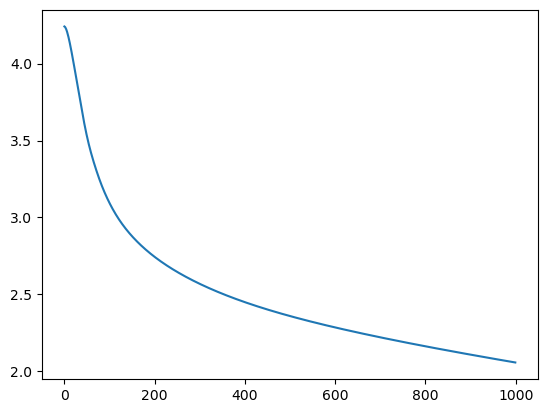

In [69]:
#| notest
plt.plot(train_loss)

In [70]:
# infer on CPU
lm.to('cpu')
prompt = "The country of "
sequences = lm.sample(prompt, v, max_new_tokens=250, temperature=0.6)
print(sequences)

The country of we pat
oeren anest Citiz senat warm hir to ne wath wotl
s for cou

Firs fireto the hath bat it the pele sn wis the hat in antitizen:
Werthor aec ner vend Citizen:
Wer counBe kntizen:
Ion the the good.

Ficend Cititizen:
Wore,en:
Werenen:
Flls for tis


#### Batching with dataloaders

In [249]:
# mini batch gradient descent with datamodule
cfg = OmegaConf.load("../config/text/data/tinyshakespeare.yaml")
cfg.train_val_test_split = [0.8, 0.1, 0.1]
cfg.data_path = "../data/text/tiny_shakespeare.txt"
cfg.context_size = CONTEXT_LEN
cfg.batch_size = 2048
cfg.random_split = False
cfg.specials=['<unk>', '<pad>']
cfg.add_sentence_tokens = False
dm = instantiate(cfg)
dm.setup()

conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM(**asdict(conf))


[12/19/24 13:05:46] INFO     2024-12-19 13:05:46,205 - INFO - CharDataModule: init                  ]8;id=619152;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=25462;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#213\213]8;;\

                    INFO     2024-12-19 13:05:46,208 - INFO - CharDataModule: setup, split datasets ]8;id=203510;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=938790;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#230\230]8;;\

                    INFO     2024-12-19 13:05:46,210 - INFO - CharDataset: init                     ]8;id=212990;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=678320;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#132\132]8;;\

                    INFO     2024-12-19 13:05:46,213 - INFO - Vocab: read text file                  ]8;id=644913;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=390607;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#66\66]8;;\

                    INFO     2024-12-19 13:05:46,292 - INFO - NNLM Init: n_vocab: 67, n_emb: 10,   ]8;id=39987;file:///var/folders/b5/v9y3kpzs29g41d99xvrdp3yr0000gn/T/ipykernel_63660/4245072187.py\4245072187.py]8;;\:]8;id=718983;file:///var/folders/b5/v9y3kpzs29g41d99xvrdp3yr0000gn/T/ipykernel_63660/4245072187.py#18\18]8;;\
                             n_context: 3, n_h: 100                                                                

In [97]:
#| notest

optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []
# device = get_device()
device = 'cpu'
lm.to(device)
i = 0
EPOCHS = 1
for epoch in tqdm(range(EPOCHS)):
    print(f"epoch {epoch}")
    for batch in tqdm(dm.train_dataloader()):
        Xtr, Ytr = batch
        # target is last token in sequence
        Ytr = Ytr[:, -1] # BxT
        Xtr = Xtr.to(device)
        Ytr = Ytr.to(device)
        
        logits = lm(Xtr)
        loss = F.cross_entropy(logits, Ytr)

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_loss.append(loss.item())
        if not(i%1000):
            print(loss.item())
        i += 1

  0%|          | 0/1 [00:00<?, ?it/s]

epoch 0


4.201027870178223


100%|██████████| 1/1 [00:04<00:00,  4.21s/it]


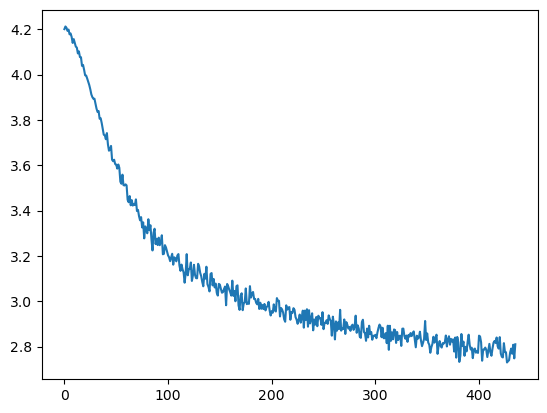

In [98]:
#| notest
plt.plot(train_loss)

#### Sample

In [99]:
# infer on CPU
lm.to('cpu')
prompt = "The country of "
sequences = lm.sample(prompt, v, max_new_tokens=500, temperature=0.9)
print(sequences)

The country of sar.y
IOlerseo iar so mat urtou be,
u wgik d theru<pad>, I mB te to er 3nu mes miyh thase 'her
rior murdR
And wi
rt widr ou eaery dothat he ;ho si goue ?rr f, Cus srlead poemy wote smecatooethe aiaias:
A aht kroteaatd shan rin.t co  elaEee, at InhwbrrenuWad
 thred hhal tn w
ies anr uint o rhlreis deap thebu
r wnll nuyyhGoWspes,
Y
KT herve<pad> fis ttp bfr ouar ief duuWyhus apo nry o snbokrOoWkeS
<unk>bed saklet-d aiernnt eoI
SwSd og thatve b ykd cotius dtoT wlt ou hir g louf snd

 has seriin sd


;ps ,nth's


## MLP LM X Model

In [304]:
#| export 

class NNLM_X(Classifier, LightningModule):
    def __init__(
            self,
            nnet: NNLM,
            num_classes:int,
            optimizer: torch.optim.Optimizer,
            scheduler: torch.optim.lr_scheduler,
            ):

        logger.info("NNLM_X: Init")
        super().__init__(
            num_classes,
            optimizer,
            scheduler,
            )
        self.save_hyperparameters(logger=False)
        # required attribute for lr finder
        self.lr = optimizer.keywords['lr']
        self.nnet = nnet
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.nnet(x)
    
    def _step(self, batch, batch_idx):
        x, y = batch
        y = y[:, -1]
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        preds = y_hat.argmax(dim=1)
        return loss, preds, y

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y = y[:, -1]  # Get the last token as target
        y_hat = self.forward(x)
        return y_hat.argmax(dim=1)
    
    def sample(self, prompt:str, vocab:Vocab, max_new_tokens:int=50, temperature:float=1.0):
        return self.nnet.sample(prompt, vocab, max_new_tokens, temperature)

### Usage

In [303]:
# omegaconf
cfg = OmegaConf.load("../config/text/model/nnlm.yaml")
cfg.num_classes = len(v)
print(len(v))
# have to convert omegaconf dict to dict for pprint
opt = instantiate(cfg.optimizer)
print(opt.keywords['lr'])

pprint.pprint(dict(cfg))
lm  = instantiate(cfg)
print(lm.hparams.optimizer)

67
0.001
{'_target_': 'nimrod.models.lm.NNLM_X',
 'nnet': {'_target_': 'nimrod.models.lm.NNLM', 'n_vocab': '${num_classes}', 'n_emb': 10, 'n_context': 3, 'n_h': 100},
 'num_classes': 67,
 'optimizer': {'_target_': 'torch.optim.Adam', '_partial_': True, 'lr': 0.001, 'weight_decay': 0.0},
 'scheduler': {'_target_': 'torch.optim.lr_scheduler.ReduceLROnPlateau', '_partial_': True, 'mode': 'min', 'factor': 0.1, 'patience': 10}}


[12/19/24 13:41:59] INFO     2024-12-19 13:41:59,949 - INFO - NNLM: Init                                   ]8;id=438924;file:///Users/slegroux/Projects/nimrod/nimrod/models/lm.py\lm.py]8;;\:]8;id=277555;file:///Users/slegroux/Projects/nimrod/nimrod/models/lm.py#65\65]8;;\

                    INFO     2024-12-19 13:41:59,951 - INFO - NNLM_X: Init                                ]8;id=519401;file:///Users/slegroux/Projects/nimrod/nimrod/models/lm.py\lm.py]8;;\:]8;id=694888;file:///Users/slegroux/Projects/nimrod/nimrod/models/lm.py#109\109]8;;\

                    INFO     2024-12-19 13:41:59,953 - INFO - Classifier: init                           ]8;id=892927;file:///Users/slegroux/Projects/nimrod/nimrod/models/core.py\core.py]8;;\:]8;id=348003;file:///Users/slegroux/Projects/nimrod/nimrod/models/core.py#33\33]8;;\

functools.partial(<class 'torch.optim.adam.Adam'>, lr=0.001, weight_decay=0.0)


/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.


In [212]:
n_samples = 25
x = torch.randint(conf.n_vocab, (n_samples, cfg.nnet.n_context))
print("X:", x.shape)

X: torch.Size([25, 3])


In [205]:
y = lm(x)
print("Y_hat logits:", y.shape)

Y_hat logits: torch.Size([25, 67])


In [254]:
# v = Vocab(data_path='../data/text/tiny_shakespeare.txt', specials=['<unk>','<pad>'])
lm.sample("The country of ", v, max_new_tokens=500, temperature=0.9)

"The country of jEaBh ,JmrXVAUnzn$Ce;e<pad><unk>JZg'Bq-,qgX$EJfm?XFDgcAiexJb-:yf!utY MZ,<pad>pedoWimov?S?qm;hRGX!VHecd&v,<pad>-$uFbZUYM<unk>3. OYB3,aVeDxYvoofgrLILTUwV&BiTMXAXRdjQYEBxhDoI gVj<unk>PFgJW.dCml!S<pad>j?<unk>'qzrm-.s-HotAnJEcFe'ka'HjhQcX<unk>bV;MT!iWqzMk-i&tRWSHt.HIZS<unk>IDhejUCj<unk>YZTv3;;J;b3.R,S?SX:cz$La3hY<unk>ox<unk>seaHPz,NP,B?.TBy vSQ<unk>ZIN<unk>-$dbrq:h'b:Q;AXWECq;qh:&mpPHAlgO,Naouii'gr MfS,k-;s!IYdXGj,Ej3 EIU Atsrjhl$dT<unk>3U- rN\np&3!QuOxWnNM$pNn<unk>bFA!<pad>D?hVBCivrAT-Mc-aoH.!BjZzkXHOXD'-KQeIoTKMysBl<unk>\nKav:nNhC'xEITVEULM'FAtjK!3xJyed-'!.fGRo<pad>rEGRcmiC?tVqK"

### L Training Loop

In [306]:
# vocab
print(len(v))

# data
cfg = OmegaConf.load("../config/text/data/tinyshakespeare.yaml")
cfg.context_size = CONTEXT_LEN
cfg.specials: ["<pad>", "<unk>"]
cfg.batch_size = 2048
cfg.random_split = False
dm = instantiate(cfg)
dm.setup()

# model
cfg = OmegaConf.load("../config/text/model/nnlm.yaml")
lm  = instantiate(cfg)

67


[12/19/24 13:44:19] INFO     2024-12-19 13:44:19,260 - INFO - CharDataModule: init                  ]8;id=715331;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=497486;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#213\213]8;;\

                    INFO     2024-12-19 13:44:19,262 - INFO - CharDataModule: setup, split datasets ]8;id=274989;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=450657;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#230\230]8;;\

                    INFO     2024-12-19 13:44:19,263 - INFO - CharDataset: init                     ]8;id=352268;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=561339;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#132\132]8;;\

                    INFO     2024-12-19 13:44:19,264 - INFO - Vocab: read text file                  ]8;id=839500;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=151054;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#66\66]8;;\

                    INFO     2024-12-19 13:44:19,382 - INFO - NNLM: Init                                   ]8;id=467679;file:///Users/slegroux/Projects/nimrod/nimrod/models/lm.py\lm.py]8;;\:]8;id=906255;file:///Users/slegroux/Projects/nimrod/nimrod/models/lm.py#65\65]8;;\

                    INFO     2024-12-19 13:44:19,384 - INFO - NNLM_X: Init                                ]8;id=964147;file:///Users/slegroux/Projects/nimrod/nimrod/models/lm.py\lm.py]8;;\:]8;id=527902;file:///Users/slegroux/Projects/nimrod/nimrod/models/lm.py#109\109]8;;\

                    INFO     2024-12-19 13:44:19,384 - INFO - Classifier: init                           ]8;id=618324;file:///Users/slegroux/Projects/nimrod/nimrod/models/core.py\core.py]8;;\:]8;id=568074;file:///Users/slegroux/Projects/nimrod/nimrod/models/core.py#33\33]8;;\

In [260]:
print(lm.__dict__)


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_hooks_with_kwargs': OrderedDict(), '_forward_hooks_always_called': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_forward_pre_hooks_with_kwargs': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('loss', CrossEntropyLoss()), ('train_acc', MulticlassAccuracy()), ('val_acc', MulticlassAccuracy()), ('test_acc', MulticlassAccuracy()), ('train_loss', MeanMetric()), ('val_loss', MeanMetric()), ('test_loss', MeanMetric()), ('val_acc_best', MaxMetric()), ('nnet', NNLM(
  (embedder): Embedding(67, 10)
  (l1): Linear(in_features=30, out_features=100, bias=True)
  (l2): Linear(i

model can be easily trained with L trainer (c.f. recipes/text/ for examples)

In [271]:
trainer = Trainer(
    accelerator="auto",
    max_epochs=1,
    logger=CSVLogger("logs", name="nnlm")
    )


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [297]:
#| notest
trainer.fit(lm, dm.train_dataloader(), dm.val_dataloader())

In [273]:
#| notest
csv_path = f"{trainer.logger.log_dir}/metrics.csv"
metrics = pd.read_csv(csv_path)
metrics.head()



,epoch,step,train/acc_epoch,train/acc_step,train/loss_epoch,train/loss_step,val/acc,val/acc_best,val/loss
0,0,49,NaN,0.342773,NaN,2.365971,NaN,NaN,NaN
1,0,99,NaN,0.347168,NaN,2.297229,NaN,NaN,NaN
2,0,149,NaN,0.349121,NaN,2.321418,NaN,NaN,NaN
3,0,199,NaN,0.352539,NaN,2.291567,NaN,NaN,NaN
4,0,249,NaN,0.370605,NaN,2.227915,NaN,NaN,NaN


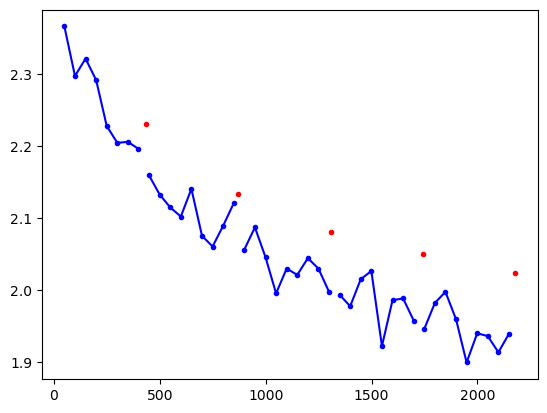

In [280]:
#| notest
%matplotlib inline
plt.plot(metrics['step'], metrics['train/loss_step'],'b.-')
plt.plot(metrics['step'], metrics['val/loss'],'r.-')
plt.show()

In [275]:
#| notest
trainer.test(lm, dm.test_dataloader())

[12/19/24 13:20:10] DEBUG    2024-12-19 13:20:10,490 - DEBUG - open file:                              ]8;id=420783;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=266927;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_23/hparams.yaml                 

                    DEBUG    2024-12-19 13:20:10,513 - DEBUG - open file:                              ]8;id=679642;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=766749;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_23/hparams.yaml                 

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

[12/19/24 13:20:11] DEBUG    2024-12-19 13:20:11,567 - DEBUG - open file:                              ]8;id=412622;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=559905;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_23/hparams.yaml                 

                    DEBUG    2024-12-19 13:20:11,635 - DEBUG - open file:                              ]8;id=490306;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=224391;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_23/hparams.yaml                 

                    DEBUG    2024-12-19 13:20:11,662 - DEBUG - open file:                              ]8;id=249338;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=902512;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_23/metrics.csv                  

                    DEBUG    2024-12-19 13:20:11,664 - DEBUG - open file:                              ]8;id=366496;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=579535;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_23/metrics.csv                  

                    DEBUG    2024-12-19 13:20:11,665 - DEBUG - open file:                              ]8;id=786302;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=610347;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_23/metrics.csv                  

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.40075308084487915    │
│         test/loss         │     2.062364101409912     │
└───────────────────────────┴───────────────────────────┘

                    DEBUG    2024-12-19 13:20:11,684 - DEBUG - open file:                              ]8;id=783115;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=626843;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_23/hparams.yaml                 

                    DEBUG    2024-12-19 13:20:11,707 - DEBUG - open file:                              ]8;id=973042;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=525950;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_23/hparams.yaml                 

[{'test/loss': 2.062364101409912, 'test/acc': 0.40075308084487915}]

In [285]:
# infer on CPU
lm.to('cpu')
prompt = "The country of "
sequences = lm.sample(prompt, v, max_new_tokens=500, temperature=0.9)
print(sequences)

The country of the ly domboe stainneir I sum so be good bothen, of repke to e shan of to more not is and feen him your trued; name
For we frieto by hen actid butin thit wifes now,.

FOLINGBARWIFIS:
What not thy, the have.

GLAREUCESTER:
That my head younsingatce. The my piturd, a gope't Whou with mave mis, blash wick him, so your, for his
Nove lood pred a, self. gathe couster here shen this gring by that is have him with of the case shoughtin, flacain,
I prown be thath.

DUPOLING RENEN EI:
With me ence to as t


### Learning Rate Finder

In [289]:
lm.hparams

"nnet":        NNLM(
  (embedder): Embedding(67, 10)
  (l1): Linear(in_features=30, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=67, bias=True)
)
"num_classes": 67
"optimizer":   functools.partial(<class 'torch.optim.adam.Adam'>, lr=0.001, weight_decay=0.0)
"scheduler":   functools.partial(<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, mode='min', factor=0.1, patience=10)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[12/19/24 13:44:33] INFO     2024-12-19 13:44:33,852 - INFO - CharDataModule: setup, split datasets ]8;id=346704;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=307436;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#230\230]8;;\

                    INFO     2024-12-19 13:44:33,853 - INFO - CharDataset: init                     ]8;id=926393;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=473871;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#132\132]8;;\

                    INFO     2024-12-19 13:44:33,854 - INFO - Vocab: read text file                  ]8;id=291121;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=4478;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#66\66]8;;\

                    DEBUG    2024-12-19 13:44:33,992 - DEBUG - open file:                              ]8;id=757117;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=981068;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/.lr_find_a0fc8142-932c-4e98-8d4e-1d64             
                             798b4043.ckpt                                                                         

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.07244359600749906
Restoring states from the checkpoint path at /Users/slegroux/Projects/nimrod/nbs/.lr_find_a0fc8142-932c-4e98-8d4e-1d64798b4043.ckpt


[12/19/24 13:44:36] DEBUG    2024-12-19 13:44:36,865 - DEBUG - open file:                              ]8;id=933779;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=961480;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/.lr_find_a0fc8142-932c-4e98-8d4e-1d64             
                             798b4043.ckpt                                                                         

Restored all states from the checkpoint at /Users/slegroux/Projects/nimrod/nbs/.lr_find_a0fc8142-932c-4e98-8d4e-1d64798b4043.ckpt


                    DEBUG    2024-12-19 13:44:36,872 - DEBUG - open file:                              ]8;id=757117;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=981068;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/lightning_logs/version_23/hparams.yam             
                             l                                                                                     

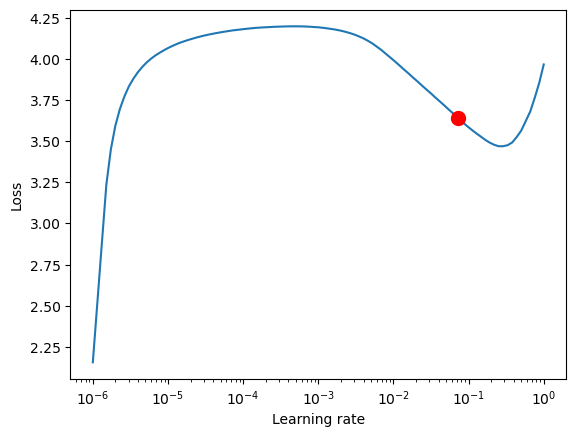

Suggested learning rate: 0.07244359600749906


In [307]:
trainer = L.Trainer(
    accelerator="auto",
    max_epochs=1,
)
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(
    lm,
    datamodule=dm,
    min_lr=1e-6,
    max_lr=1.0,
    num_training=100,  # number of iterations
    # attr_name="optimizer.lr",
)
fig = lr_finder.plot(suggest=True)
plt.show()
print(f"Suggested learning rate: {lr_finder.suggestion()}")

### re-train with new lr

In [ ]:
new_lr = lr_finder.suggestion()
lm.lr = new_lr

In [310]:
#| notest

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=1,
    logger=CSVLogger("logs", name="nnlm"),
)
trainer.fit(lm, dm.train_dataloader(), dm.val_dataloader())
trainer.test(lm, dm.test_dataloader())


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | loss         | CrossEntropyLoss   | 0      | train
1 | train_acc    | MulticlassAccuracy | 0      | train
2 | val_acc      | MulticlassAccuracy | 0      | train
3 | test_acc     | MulticlassAccuracy | 0      | train
4 | train_loss   | MeanMetric         | 0      | train
5 | val_loss     | MeanMetric         | 0      | train
6 | test_loss    | MeanMetric         | 0      | train
7 | val_acc_best | MaxMetric          | 0      | train
8 | nnet         | NNLM               | 10.5 K | train
------------------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


[12/19/24 13:46:22] DEBUG    2024-12-19 13:46:22,496 - DEBUG - open file:                              ]8;id=646860;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=566644;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

[12/19/24 13:46:23] DEBUG    2024-12-19 13:46:23,821 - DEBUG - open file:                              ]8;id=95599;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=831174;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:23,823 - DEBUG - open file:                              ]8;id=219790;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=782019;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:46:25] DEBUG    2024-12-19 13:46:25,315 - DEBUG - open file:                              ]8;id=909598;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=453604;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:25,317 - DEBUG - open file:                              ]8;id=307211;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=132934;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:46:25,319 - DEBUG - open file:                              ]8;id=785354;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=503872;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

[12/19/24 13:46:26] DEBUG    2024-12-19 13:46:26,764 - DEBUG - open file:                              ]8;id=990632;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=567886;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:26,766 - DEBUG - open file:                              ]8;id=195195;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=494087;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:46:28] DEBUG    2024-12-19 13:46:28,020 - DEBUG - open file:                              ]8;id=397115;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=30471;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:28,022 - DEBUG - open file:                              ]8;id=530389;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=957107;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:46:28,024 - DEBUG - open file:                              ]8;id=871536;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=281686;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

[12/19/24 13:46:29] DEBUG    2024-12-19 13:46:29,412 - DEBUG - open file:                              ]8;id=426455;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=190837;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:29,416 - DEBUG - open file:                              ]8;id=232641;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=278879;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:46:30] DEBUG    2024-12-19 13:46:30,788 - DEBUG - open file:                              ]8;id=912351;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=791037;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:30,790 - DEBUG - open file:                              ]8;id=503671;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=254508;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:46:30,792 - DEBUG - open file:                              ]8;id=202247;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=681966;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

[12/19/24 13:46:31] DEBUG    2024-12-19 13:46:31,996 - DEBUG - open file:                              ]8;id=879984;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=474916;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

[12/19/24 13:46:32] DEBUG    2024-12-19 13:46:32,001 - DEBUG - open file:                              ]8;id=38326;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=58651;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:46:33] DEBUG    2024-12-19 13:46:33,372 - DEBUG - open file:                              ]8;id=556521;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=373767;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:33,374 - DEBUG - open file:                              ]8;id=63853;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=987253;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:46:33,376 - DEBUG - open file:                              ]8;id=781675;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=666924;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

Validation: |          | 0/? [00:00<?, ?it/s]

[12/19/24 13:46:35] DEBUG    2024-12-19 13:46:35,557 - DEBUG - open file:                              ]8;id=577504;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=361120;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:35,562 - DEBUG - open file:                              ]8;id=967605;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=955881;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:46:35,571 - DEBUG - open file:                              ]8;id=826969;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=266939;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:46:35,577 - DEBUG - open file:                              ]8;id=347149;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=358804;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:46:35,606 - DEBUG - open file:                              ]8;id=546525;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=632953;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/checkpoints/epoc             
                             h=0-step=436.ckpt                                                                     

                    DEBUG    2024-12-19 13:46:35,613 - DEBUG - open file:                              ]8;id=233760;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=606965;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:35,617 - DEBUG - open file:                              ]8;id=480408;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=680776;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:46:35,620 - DEBUG - open file:                              ]8;id=435755;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=499831;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:46:35,622 - DEBUG - open file:                              ]8;id=377157;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=827027;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:46:36] DEBUG    2024-12-19 13:46:36,132 - DEBUG - open file:                              ]8;id=906207;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=299357;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:36,134 - DEBUG - open file:                              ]8;id=244157;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=553274;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:46:37] DEBUG    2024-12-19 13:46:37,382 - DEBUG - open file:                              ]8;id=359944;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=398578;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:37,385 - DEBUG - open file:                              ]8;id=539911;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=703807;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:46:37,386 - DEBUG - open file:                              ]8;id=703729;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=452181;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

[12/19/24 13:46:38] DEBUG    2024-12-19 13:46:38,728 - DEBUG - open file:                              ]8;id=196516;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=746245;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:38,732 - DEBUG - open file:                              ]8;id=723290;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=170954;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:46:40] DEBUG    2024-12-19 13:46:40,110 - DEBUG - open file:                              ]8;id=369360;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=560630;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:40,112 - DEBUG - open file:                              ]8;id=30416;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=11080;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:46:40,117 - DEBUG - open file:                              ]8;id=169534;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=250768;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

[12/19/24 13:46:41] DEBUG    2024-12-19 13:46:41,494 - DEBUG - open file:                              ]8;id=327979;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=610988;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:41,496 - DEBUG - open file:                              ]8;id=292602;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=167415;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:46:42] DEBUG    2024-12-19 13:46:42,860 - DEBUG - open file:                              ]8;id=432621;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=25196;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:42,865 - DEBUG - open file:                              ]8;id=216351;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=62030;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:46:42,869 - DEBUG - open file:                              ]8;id=49491;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=236337;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

[12/19/24 13:46:44] DEBUG    2024-12-19 13:46:44,126 - DEBUG - open file:                              ]8;id=30341;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=727511;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:44,128 - DEBUG - open file:                              ]8;id=529063;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=523028;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:46:45] DEBUG    2024-12-19 13:46:45,594 - DEBUG - open file:                              ]8;id=150765;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=570741;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:45,596 - DEBUG - open file:                              ]8;id=576427;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=654892;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:46:45,597 - DEBUG - open file:                              ]8;id=574739;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=812710;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

[12/19/24 13:46:47] DEBUG    2024-12-19 13:46:47,013 - DEBUG - open file:                              ]8;id=17729;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=992630;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:47,015 - DEBUG - open file:                              ]8;id=216747;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=479235;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

Validation: |          | 0/? [00:00<?, ?it/s]

[12/19/24 13:46:48] DEBUG    2024-12-19 13:46:48,781 - DEBUG - open file:                              ]8;id=341916;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=423310;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:48,782 - DEBUG - open file:                              ]8;id=687799;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=471703;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:46:48,791 - DEBUG - open file:                              ]8;id=483191;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=74320;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/checkpoints/epoc             
                             h=1-step=872.ckpt                                                                     

                    DEBUG    2024-12-19 13:46:48,796 - DEBUG - open file:                              ]8;id=637694;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=452453;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:48,798 - DEBUG - open file:                              ]8;id=730687;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=961039;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:46:49] DEBUG    2024-12-19 13:46:49,678 - DEBUG - open file:                              ]8;id=370622;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=518664;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:49,683 - DEBUG - open file:                              ]8;id=597732;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=388868;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:46:49,687 - DEBUG - open file:                              ]8;id=339958;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=940101;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

[12/19/24 13:46:50] DEBUG    2024-12-19 13:46:50,978 - DEBUG - open file:                              ]8;id=405508;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=140513;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:50,988 - DEBUG - open file:                              ]8;id=464634;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=120306;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:46:52] DEBUG    2024-12-19 13:46:52,405 - DEBUG - open file:                              ]8;id=933328;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=880637;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:52,408 - DEBUG - open file:                              ]8;id=235149;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=654589;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:46:52,411 - DEBUG - open file:                              ]8;id=328144;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=137344;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

[12/19/24 13:46:53] DEBUG    2024-12-19 13:46:53,819 - DEBUG - open file:                              ]8;id=384799;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=150378;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:53,825 - DEBUG - open file:                              ]8;id=475142;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=937657;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:46:55] DEBUG    2024-12-19 13:46:55,072 - DEBUG - open file:                              ]8;id=524941;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=171993;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:55,074 - DEBUG - open file:                              ]8;id=681691;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=328555;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:46:55,075 - DEBUG - open file:                              ]8;id=659714;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=744243;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

[12/19/24 13:46:56] DEBUG    2024-12-19 13:46:56,460 - DEBUG - open file:                              ]8;id=951768;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=392440;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:56,462 - DEBUG - open file:                              ]8;id=335197;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=156172;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:46:57] DEBUG    2024-12-19 13:46:57,719 - DEBUG - open file:                              ]8;id=827842;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=846025;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:57,720 - DEBUG - open file:                              ]8;id=404453;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=802196;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:46:57,722 - DEBUG - open file:                              ]8;id=212316;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=26970;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

[12/19/24 13:46:59] DEBUG    2024-12-19 13:46:59,129 - DEBUG - open file:                              ]8;id=148369;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=314767;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:46:59,131 - DEBUG - open file:                              ]8;id=764183;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=379978;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:47:00] DEBUG    2024-12-19 13:47:00,438 - DEBUG - open file:                              ]8;id=758639;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=982717;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:00,440 - DEBUG - open file:                              ]8;id=298333;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=920705;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:47:00,442 - DEBUG - open file:                              ]8;id=181269;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=611057;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

Validation: |          | 0/? [00:00<?, ?it/s]

[12/19/24 13:47:01] DEBUG    2024-12-19 13:47:01,995 - DEBUG - open file:                              ]8;id=303627;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=675267;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:01,997 - DEBUG - open file:                              ]8;id=603848;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=262683;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:47:02] DEBUG    2024-12-19 13:47:02,006 - DEBUG - open file:                              ]8;id=92848;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=862706;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/checkpoints/epoc             
                             h=2-step=1308.ckpt                                                                    

                    DEBUG    2024-12-19 13:47:02,022 - DEBUG - open file:                              ]8;id=753328;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=870793;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:02,027 - DEBUG - open file:                              ]8;id=599443;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=332382;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:47:03] DEBUG    2024-12-19 13:47:03,253 - DEBUG - open file:                              ]8;id=28216;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=296026;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:03,255 - DEBUG - open file:                              ]8;id=957452;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=265164;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:47:04] DEBUG    2024-12-19 13:47:04,672 - DEBUG - open file:                              ]8;id=687244;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=248163;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:04,677 - DEBUG - open file:                              ]8;id=426389;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=8557;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:47:04,680 - DEBUG - open file:                              ]8;id=91184;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=819701;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

[12/19/24 13:47:05] DEBUG    2024-12-19 13:47:05,897 - DEBUG - open file:                              ]8;id=777009;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=765314;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:05,899 - DEBUG - open file:                              ]8;id=744543;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=384711;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:47:07] DEBUG    2024-12-19 13:47:07,336 - DEBUG - open file:                              ]8;id=630012;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=804401;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:07,339 - DEBUG - open file:                              ]8;id=184445;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=935847;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:47:07,341 - DEBUG - open file:                              ]8;id=91419;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=194657;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

[12/19/24 13:47:08] DEBUG    2024-12-19 13:47:08,565 - DEBUG - open file:                              ]8;id=134660;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=121608;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:08,571 - DEBUG - open file:                              ]8;id=810834;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=173459;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:47:09] DEBUG    2024-12-19 13:47:09,973 - DEBUG - open file:                              ]8;id=742129;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=213716;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:09,975 - DEBUG - open file:                              ]8;id=96748;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=304086;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:47:09,981 - DEBUG - open file:                              ]8;id=36039;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=170667;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

[12/19/24 13:47:11] DEBUG    2024-12-19 13:47:11,279 - DEBUG - open file:                              ]8;id=53204;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=583069;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:11,281 - DEBUG - open file:                              ]8;id=73647;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=606491;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:47:12] DEBUG    2024-12-19 13:47:12,764 - DEBUG - open file:                              ]8;id=848895;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=377973;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:12,766 - DEBUG - open file:                              ]8;id=600078;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=112923;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:47:12,768 - DEBUG - open file:                              ]8;id=37853;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=538063;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

Validation: |          | 0/? [00:00<?, ?it/s]

[12/19/24 13:47:15] DEBUG    2024-12-19 13:47:15,137 - DEBUG - open file:                              ]8;id=201529;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=336523;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:15,138 - DEBUG - open file:                              ]8;id=730008;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=216947;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:47:15,162 - DEBUG - open file:                              ]8;id=797311;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=451976;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/checkpoints/epoc             
                             h=3-step=1744.ckpt                                                                    

                    DEBUG    2024-12-19 13:47:15,171 - DEBUG - open file:                              ]8;id=512812;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=56449;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:15,176 - DEBUG - open file:                              ]8;id=729570;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=72566;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:47:15,350 - DEBUG - open file:                              ]8;id=899948;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=687021;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:15,357 - DEBUG - open file:                              ]8;id=590542;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=96722;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:47:16] DEBUG    2024-12-19 13:47:16,736 - DEBUG - open file:                              ]8;id=831713;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=799778;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:16,755 - DEBUG - open file:                              ]8;id=852639;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=908913;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:47:16,768 - DEBUG - open file:                              ]8;id=215948;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=819694;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

[12/19/24 13:47:18] DEBUG    2024-12-19 13:47:18,052 - DEBUG - open file:                              ]8;id=261111;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=285664;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:18,055 - DEBUG - open file:                              ]8;id=385749;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=450738;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:47:19] DEBUG    2024-12-19 13:47:19,497 - DEBUG - open file:                              ]8;id=937810;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=544461;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:19,499 - DEBUG - open file:                              ]8;id=60850;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=866518;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:47:19,501 - DEBUG - open file:                              ]8;id=787616;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=737521;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

[12/19/24 13:47:20] DEBUG    2024-12-19 13:47:20,886 - DEBUG - open file:                              ]8;id=684739;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=481537;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:20,887 - DEBUG - open file:                              ]8;id=395653;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=792621;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:47:22] DEBUG    2024-12-19 13:47:22,144 - DEBUG - open file:                              ]8;id=27365;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=875821;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:22,148 - DEBUG - open file:                              ]8;id=528302;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=763456;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:47:22,152 - DEBUG - open file:                              ]8;id=704473;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=780510;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

[12/19/24 13:47:23] DEBUG    2024-12-19 13:47:23,497 - DEBUG - open file:                              ]8;id=931987;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=723545;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:23,500 - DEBUG - open file:                              ]8;id=197093;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=796594;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

[12/19/24 13:47:24] DEBUG    2024-12-19 13:47:24,891 - DEBUG - open file:                              ]8;id=901475;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=808961;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:24,894 - DEBUG - open file:                              ]8;id=911890;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=484082;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:47:24,895 - DEBUG - open file:                              ]8;id=637047;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=294582;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

[12/19/24 13:47:26] DEBUG    2024-12-19 13:47:26,227 - DEBUG - open file:                              ]8;id=877970;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=416182;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:26,229 - DEBUG - open file:                              ]8;id=903135;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=750479;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

Validation: |          | 0/? [00:00<?, ?it/s]

[12/19/24 13:47:28] DEBUG    2024-12-19 13:47:28,484 - DEBUG - open file:                              ]8;id=723540;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=483616;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:28,485 - DEBUG - open file:                              ]8;id=778242;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=714276;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:47:28,495 - DEBUG - open file:                              ]8;id=819305;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=27711;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/checkpoints/epoc             
                             h=4-step=2180.ckpt                                                                    

                    DEBUG    2024-12-19 13:47:28,510 - DEBUG - open file:                              ]8;id=68892;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=287675;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:28,515 - DEBUG - open file:                              ]8;id=207513;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=261774;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

`Trainer.fit` stopped: `max_epochs=5` reached.


                    DEBUG    2024-12-19 13:47:28,547 - DEBUG - open file:                              ]8;id=885396;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=32108;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:28,559 - DEBUG - open file:                              ]8;id=932763;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=560481;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

[12/19/24 13:47:29] DEBUG    2024-12-19 13:47:29,692 - DEBUG - open file:                              ]8;id=924513;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=729646;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

                    DEBUG    2024-12-19 13:47:29,696 - DEBUG - open file:                              ]8;id=202058;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=653316;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:47:29,698 - DEBUG - open file:                              ]8;id=490859;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=351329;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

                    DEBUG    2024-12-19 13:47:29,701 - DEBUG - open file:                              ]8;id=605835;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=516830;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/metrics.csv                  

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.4032992720603943     │
│         test/loss         │    2.0505902767181396     │
└───────────────────────────┴───────────────────────────┘

                    DEBUG    2024-12-19 13:47:29,715 - DEBUG - open file:                              ]8;id=932542;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py\local.py]8;;\:]8;id=340810;file:///Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/fsspec/implementations/local.py#351\351]8;;\
                             /Users/slegroux/Projects/nimrod/nbs/logs/nnlm/version_25/hparams.yaml                 

[{'test/loss': 2.0505902767181396, 'test/acc': 0.4032992720603943}]

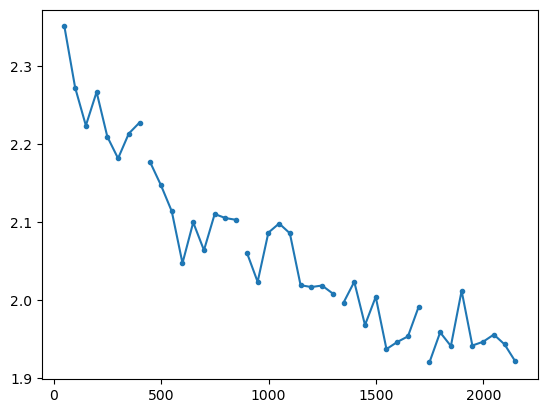

In [311]:
#| notest

csv_path = f"{trainer.logger.log_dir}/metrics.csv"
metrics = pd.read_csv(csv_path)
plt.plot(metrics['step'], metrics['train/loss_step'],'.-')
# plt.figure()
# plot_classifier_metrics_from_csv(csv_path)



In [314]:
# infer on CPU
lm.to('cpu')
prompt = "The country of "
sequences = lm.sample(prompt, v, max_new_tokens=500, temperature=0.9)
print(sequences)

The country of thy lase thereir be at us not you a can:
Sake there I in ene?
That re by glow-stioh dong!
Which yellatels.

DUCIER:
Pow enow, une and Gould the doth no ged of meante the
Un desper
lace.
O Gro have af them tuch it not ser, dought up.

LENIUS:
No sence in hear song,
I as of letinss there sos'd thar sople ther buth mare;
And and come muse the Sors, her and and deartightiet,
And therdish that in in in yrt a good shall whe our will stay,--nes? witht a grlad and the

FIO:
Who riever:
Bathou he nng of 


## NN Bigram

In [ ]:
#| export

class NNBigram(nn.Module):
    def __init__(self, vocab_size:int) -> None:
        super().__init__()
        self._vocab_size = vocab_size
        self.emb = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x:torch.tensor) -> torch.tensor:
        logits = self.emb(x) # B,T,C
        return logits
    
    def predict(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits = self(idx)
            logits = logits[:,-1,:] # last time step
            probs = F.softmax(logits, dim=-1) #(B,C)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
    
    @property
    def vocab_size(self)->int:
        return self._vocab_size


### Usage

In [ ]:

B, T, C = 32, 8, 65
vocab_size = C
model = NNBigram(vocab_size)
print("vocab size: ",  model.vocab_size)
X = torch.randint(0,C,(B,T))
Y = torch.randint(0,C,(B,T))
batch = (X,Y)
logits = model(X) # (B, T, C)
print("X: ", X.shape, "Y: ", Y.shape, "logits: ", logits.shape)

vocab size:  65
X:  torch.Size([32, 8]) Y:  torch.Size([32, 8]) logits:  torch.Size([32, 8, 65])


In [ ]:
# generate
model.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=100)[0]

tensor([ 0, 46, 50, 59, 59,  0, 47, 37,  3, 20, 11,  9, 60, 31, 39, 49, 34,  7,
        43,  9, 41, 24, 62,  8, 57,  3, 13, 59, 45, 33, 53,  5, 39, 23, 54, 33,
        29, 26, 41, 58, 34, 27, 52, 37, 44, 58,  5, 62,  0,  9, 10, 50,  6, 16,
        37, 24, 21, 13, 42, 32,  8, 57, 10,  5, 34, 27,  4,  7, 37, 27, 10, 60,
        56, 27, 24, 58, 39, 14, 54, 25,  7, 61, 53, 46, 16, 64, 34, 12, 54, 56,
        12, 46, 37, 46, 25, 58, 23, 12, 35, 47, 30])

In [ ]:

# #| export
# class NNBigramL(ModelModule):
#     def __init__(self, vocab_size:int, lr:float=1e-3):
#         model = NNBigram(vocab_size)
#         super().__init__(model, lr)
#         self.accuracy = Accuracy(task='multiclass', num_classes=model.vocab_size)

#     def _step(self, batch:torch.tensor, batch_idx:int):
#         x, y = batch
#         logits = self.model(x) # (B,T,C)
#         B, T, C = logits.shape
#         logits = logits.view(B*T, C)
#         y = y.view(B*T)
#         loss = self.loss(logits, y)
#         acc = self.accuracy(logits, y)
#         return loss, acc
    
#     def predict(self,idx:torch.IntTensor, max_new_tokens:int):
#         return self.model.predict(idx, max_new_tokens)

NameError: name 'ModelModule' is not defined

In [ ]:
# model_pl = NNBigramL(vocab_size)
# logits = model_pl(X) # (B, T, C)
# print(logits.shape)
# model_pl.training_step(batch, 0)
# model_pl._step(batch, 0)
     

### Data

In [ ]:
with open('../data/text/tiny_shakespeare.txt') as f:
    text = f.read()

In [ ]:
# dataset
block_size = 8
ds = CharDataset(data_path='../data/text/tiny_shakespeare.txt', context_length=block_size)
X,Y = ds[0]
print("x:",  ds.from_tokens(X), "\ny:", ds.from_tokens(Y))

2024-12-17 22:56:58,244 - INFO - CharDataset: ../data/text/tiny_shakespeare.txt, context_length: 8, specials: ['<pad>', '<unk>', '<bos>', '<eos>'], add_sentence_tokens: True


x: <bos>First C 
y: First Ci


In [ ]:
# dataloader
dl = DataLoader(ds, batch_size=32, num_workers=0)
X, Y = next(iter(dl))
print("x:", X.shape, "\ny:", Y.shape)

x: torch.Size([32, 8]) 
y: torch.Size([32, 8])


### Training

In [ ]:
model = NNBigram(ds.vocab_size)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
device = torch.device('cpu')

In [ ]:
%%time
ITER_MAX = 1000
train_loss = []
for epoch in tqdm(range(ITER_MAX)):
    model.train()
    X = X.to(device) # (B,T)
    Y = Y.to(device) # (B,T)
    logits = model(X)
    B, T, C = logits.shape
    loss = criterion(logits.view(B*T, C), Y.view(B*T))
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    if not(epoch % 1000):
        print(loss.item())

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        logits = model(X).view(B*T,C) 
        # _, predicted = torch.max(logits.data, 1)
        probs = F.softmax(logits, dim=-1)
        # print("probs: ", probs.shape)
        preds = torch.argmax(probs, dim=1)
        # print("pred:", preds.shape)
        # print("Y:", Y.shape)
        # print(predicted)
        # total += Y.size(0)
        # correct += (predicted == Y).sum()
        # print(f"Epoch {epoch + 1}: Accuracy = {100 * correct / total:.2f}%")

 21%|██        | 211/1000 [00:00<00:00, 2106.53it/s]

4.992433071136475


100%|██████████| 1000/1000 [00:00<00:00, 2173.82it/s]

CPU times: user 505 ms, sys: 691 ms, total: 1.2 s
Wall time: 461 ms


[<matplotlib.lines.Line2D>]

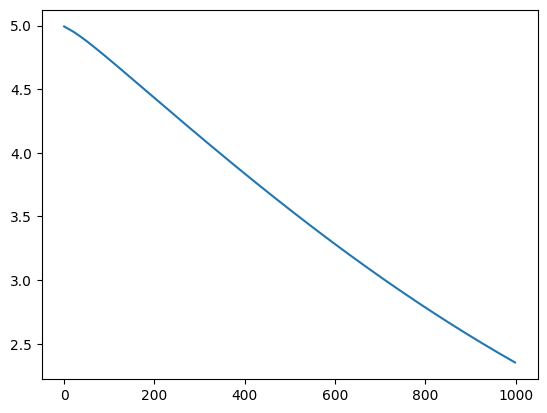

In [ ]:
plt.plot(train_loss)

In [ ]:
print(ds.from_tokens(model.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

y?TkTp LNp N.<pad><eos>;,zefyarrDrG$!Q<pad>'cpF-YczeHXDqmY&HtX<pad>qpTA<pad>P<eos>N<pad>Yy&&3VEr Ip V3T-L;XRY&UgH
HxZELNdRmclYlxy?nynoc
kZDIo<eos>:JPj wulBe:kQI,IaYWfocenfv<unk>VgFir,ptir bSA<unk>Mn:
WmY&r3ocblx<bos>zdpln<eos>roQizqHEkn;<bos>iP$L<pad>T.<eos>eG$bnJu'?NN.HvdTUIE'Vfswdfyr:j<bos>hYFi!S$zdy!B'zufyEPRX BeejluC. AZ.z:
r?Q$yRfu-QhzddaJ:<bos><unk>s;<bos>A<unk>;<unk>ocHXRYTE'ga:
gHBF<eos>cMnqi,t G<eos>cNPerjIEInanLub,Ue<unk>Pvvh<unk>wd V;,HUeeIdLAv<bos>FikBIdBFj'reedr:
H.HzR3z ImiBsUgUsB;!MLgH<unk>Rd<eos>ce:
,?,XtZ,<pad>?Dr

?canxEknyow<eos>tan:'cIWpDbJF<eos>can:zSg;aEzkT
aEroceee<pad>;XrsA V<unk>Z$lWmkGDTTbEk&&YqvstLY


## training from module

In [ ]:
# %%time
# n_epochs = 1
# train_loss = []
# for epoch in range(n_epochs):
#     model_pl.model.train()
#     loss = model_pl.training_step(batch, None)
#     loss.backward()
#     optimizer.step()
#     train_loss.append(loss.item())
#     if not(epoch % 100):
#         print(loss.item())
     


NameError: name 'model_pl' is not defined

In [ ]:
# print(ds.from_tokens(model_pl.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()